In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Installing Dependencies

In [2]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5.git  # clone repo
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 16554, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 16554 (delta 17), reused 27 (delta 13), pack-reused 16522
Receiving objects: 100% (16554/16554), 15.08 MiB | 32.37 MiB/s, done.
Resolving deltas: 100% (11374/11374), done.
/kaggle/working/yolov5


In [3]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
# from utils.google_utils import gdrive_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which is incompatible.
Setup complete. Using torch 2.1.2 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16276MB, multi_processor_count=56)


# Preparing  dataset

In [4]:
#Setup Gdrive file download extention 
!conda install -y gdown

Retrieving notices: ...working... done
done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 24.3.0

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.3.0



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    filelock-3.13.4            |     pyhd8ed1ab_0          15 KB  conda-forge
    gdown-5.1.0                |     pyhd8ed1ab_0          21 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          36 KB

The following NEW packages will be INSTALLED:

  filelock           conda-forge/noarch::filelock-3.13.4-pyhd8ed1a

In [5]:
# !gdown --id <File ID>
!gdown -- 1xMmFQEhlAq_d36JZKtMJksNQeKCvM9xf

Downloading...
From (original): https://drive.google.com/uc?id=1xMmFQEhlAq_d36JZKtMJksNQeKCvM9xf
From (redirected): https://drive.google.com/uc?id=1xMmFQEhlAq_d36JZKtMJksNQeKCvM9xf&confirm=t&uuid=ce0e008c-9ec9-471d-a750-b64c144dc911
To: /kaggle/working/yolov5/YoloV5_new.zip
100%|██████████████████████████████████████| 95.8M/95.8M [00:01<00:00, 66.2MB/s]


In [6]:
import zipfile
with zipfile.ZipFile('/kaggle/working/yolov5/YoloV5_new.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/yolov5')

In [7]:
# this is the YAML file  we're loading into this notebook with our data
%cat data.yaml

train: ../train/images
val: ../validation/images

nc: 2
names: ['porosity', 'spatter']


# Defining model configuration and architecture
#### Here we will write a yaml script that defines parameters for our model like the number of classes

In [8]:
# define number of classes based on YAML
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [9]:
num_classes

'2'

In [10]:
%cat models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license

# Parameters
nc: 80 # number of classes
depth_multiple: 0.33 # model depth multiple
width_multiple: 0.50 # layer channel multiple
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 

In [11]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [12]:
%%writetemplate models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

# Training

In [14]:
# train yolov5s on custom data for 500 epochs
%cd /kaggle/working/yolov5
!python train.py --img 640 --batch 8 --epochs 500 --data 'data.yaml' --cfg ./models/custom_yolov5s.yaml --weights 'yolov5s.pt' --name yolov5s_results  --cache

/kaggle/working/yolov5
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-04-16 14:28:51.437917: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-16 14:28:51.438037: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-16 14:28:51.585478: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due t

In [15]:
import pandas as pd


In [16]:
df = pd.read_csv("/kaggle/working/yolov5/runs/train/yolov5s_results/results.csv")
df

epoch        train/box_loss        train/obj_loss  \
0                       0              0.091171              0.035766   
1                       1              0.099642              0.030635   
2                       2              0.119510              0.038275   
3                       3              0.087648              0.030886   
4                       4              0.087198              0.039180   
..                    ...                   ...                   ...   
403                   403              0.068857              0.023804   
404                   404              0.068667              0.032329   
405                   405              0.059710              0.022155   
406                   406              0.051858              0.031822   
407                   407              0.070941              0.033494   

           train/cls_loss     metrics/precision        metrics/recall  \
0                0.019037               0.00000               0.00000   
1                0.022516               0.00000               0.00000   
2                0.025268               0.00000               0.00000   
3                0.018780               0.00000               0.00000   
4                0.018614               0.00000               0.00000   
..                    ...                   ...                   ...   
403              0.004360               0.54754               0.46429   
404              0.003608               0.49399               0.36905   
405              0.007142               0.49399               0.36905   
406              0.002279               0.34214               0.44048   
407              0.003537               0.34214               0.44048   

          metrics/mAP_0.5  metrics/mAP_0.5:0.95          val/box_loss  \
0                 0.00000               0.00000              0.081741   
1                 0.00000               0.00000              0.081368   
2                 0.00000               0.00000              0.081137   
3                 0.00000               0.00000              0.081029   
4                 0.00000               0.00000              0.080688   
..                    ...                   ...                   ...   
403               0.39345               0.11371              0.050164   
404               0.39400               0.10250              0.049408   
405               0.39400               0.10250              0.049408   
406               0.25808               0.11499              0.049409   
407               0.25808               0.11499              0.049409   

             val/obj_loss          val/cls_loss                 x/lr0  \
0                0.046383              0.018329              0.097300   
1                0.047031              0.018329              0.093699   
2                0.046673              0.018329              0.090096   
3                0.047009              0.018317              0.086491   
4                0.047539              0.018311              0.082885   
..                    ...                   ...                   ...   
403              0.041123              0.002403              0.002040   
404              0.041511              0.002817              0.002021   
405              0.041511              0.002817              0.002001   
406              0.041466              0.003027              0.001981   
407              0.041466              0.003027              0.001961   

                    x/lr1                 x/lr2  
0                0.000300              0.000300  
1                0.000699              0.000699  
2                0.001096              0.001096  
3                0.001491              0.001491  
4                0.001885              0.001885  
..                    ...                   ...  
403              0.002040              0.002040  
404              0.002021              0.002021  
405              0.002001              0.002001  
406         

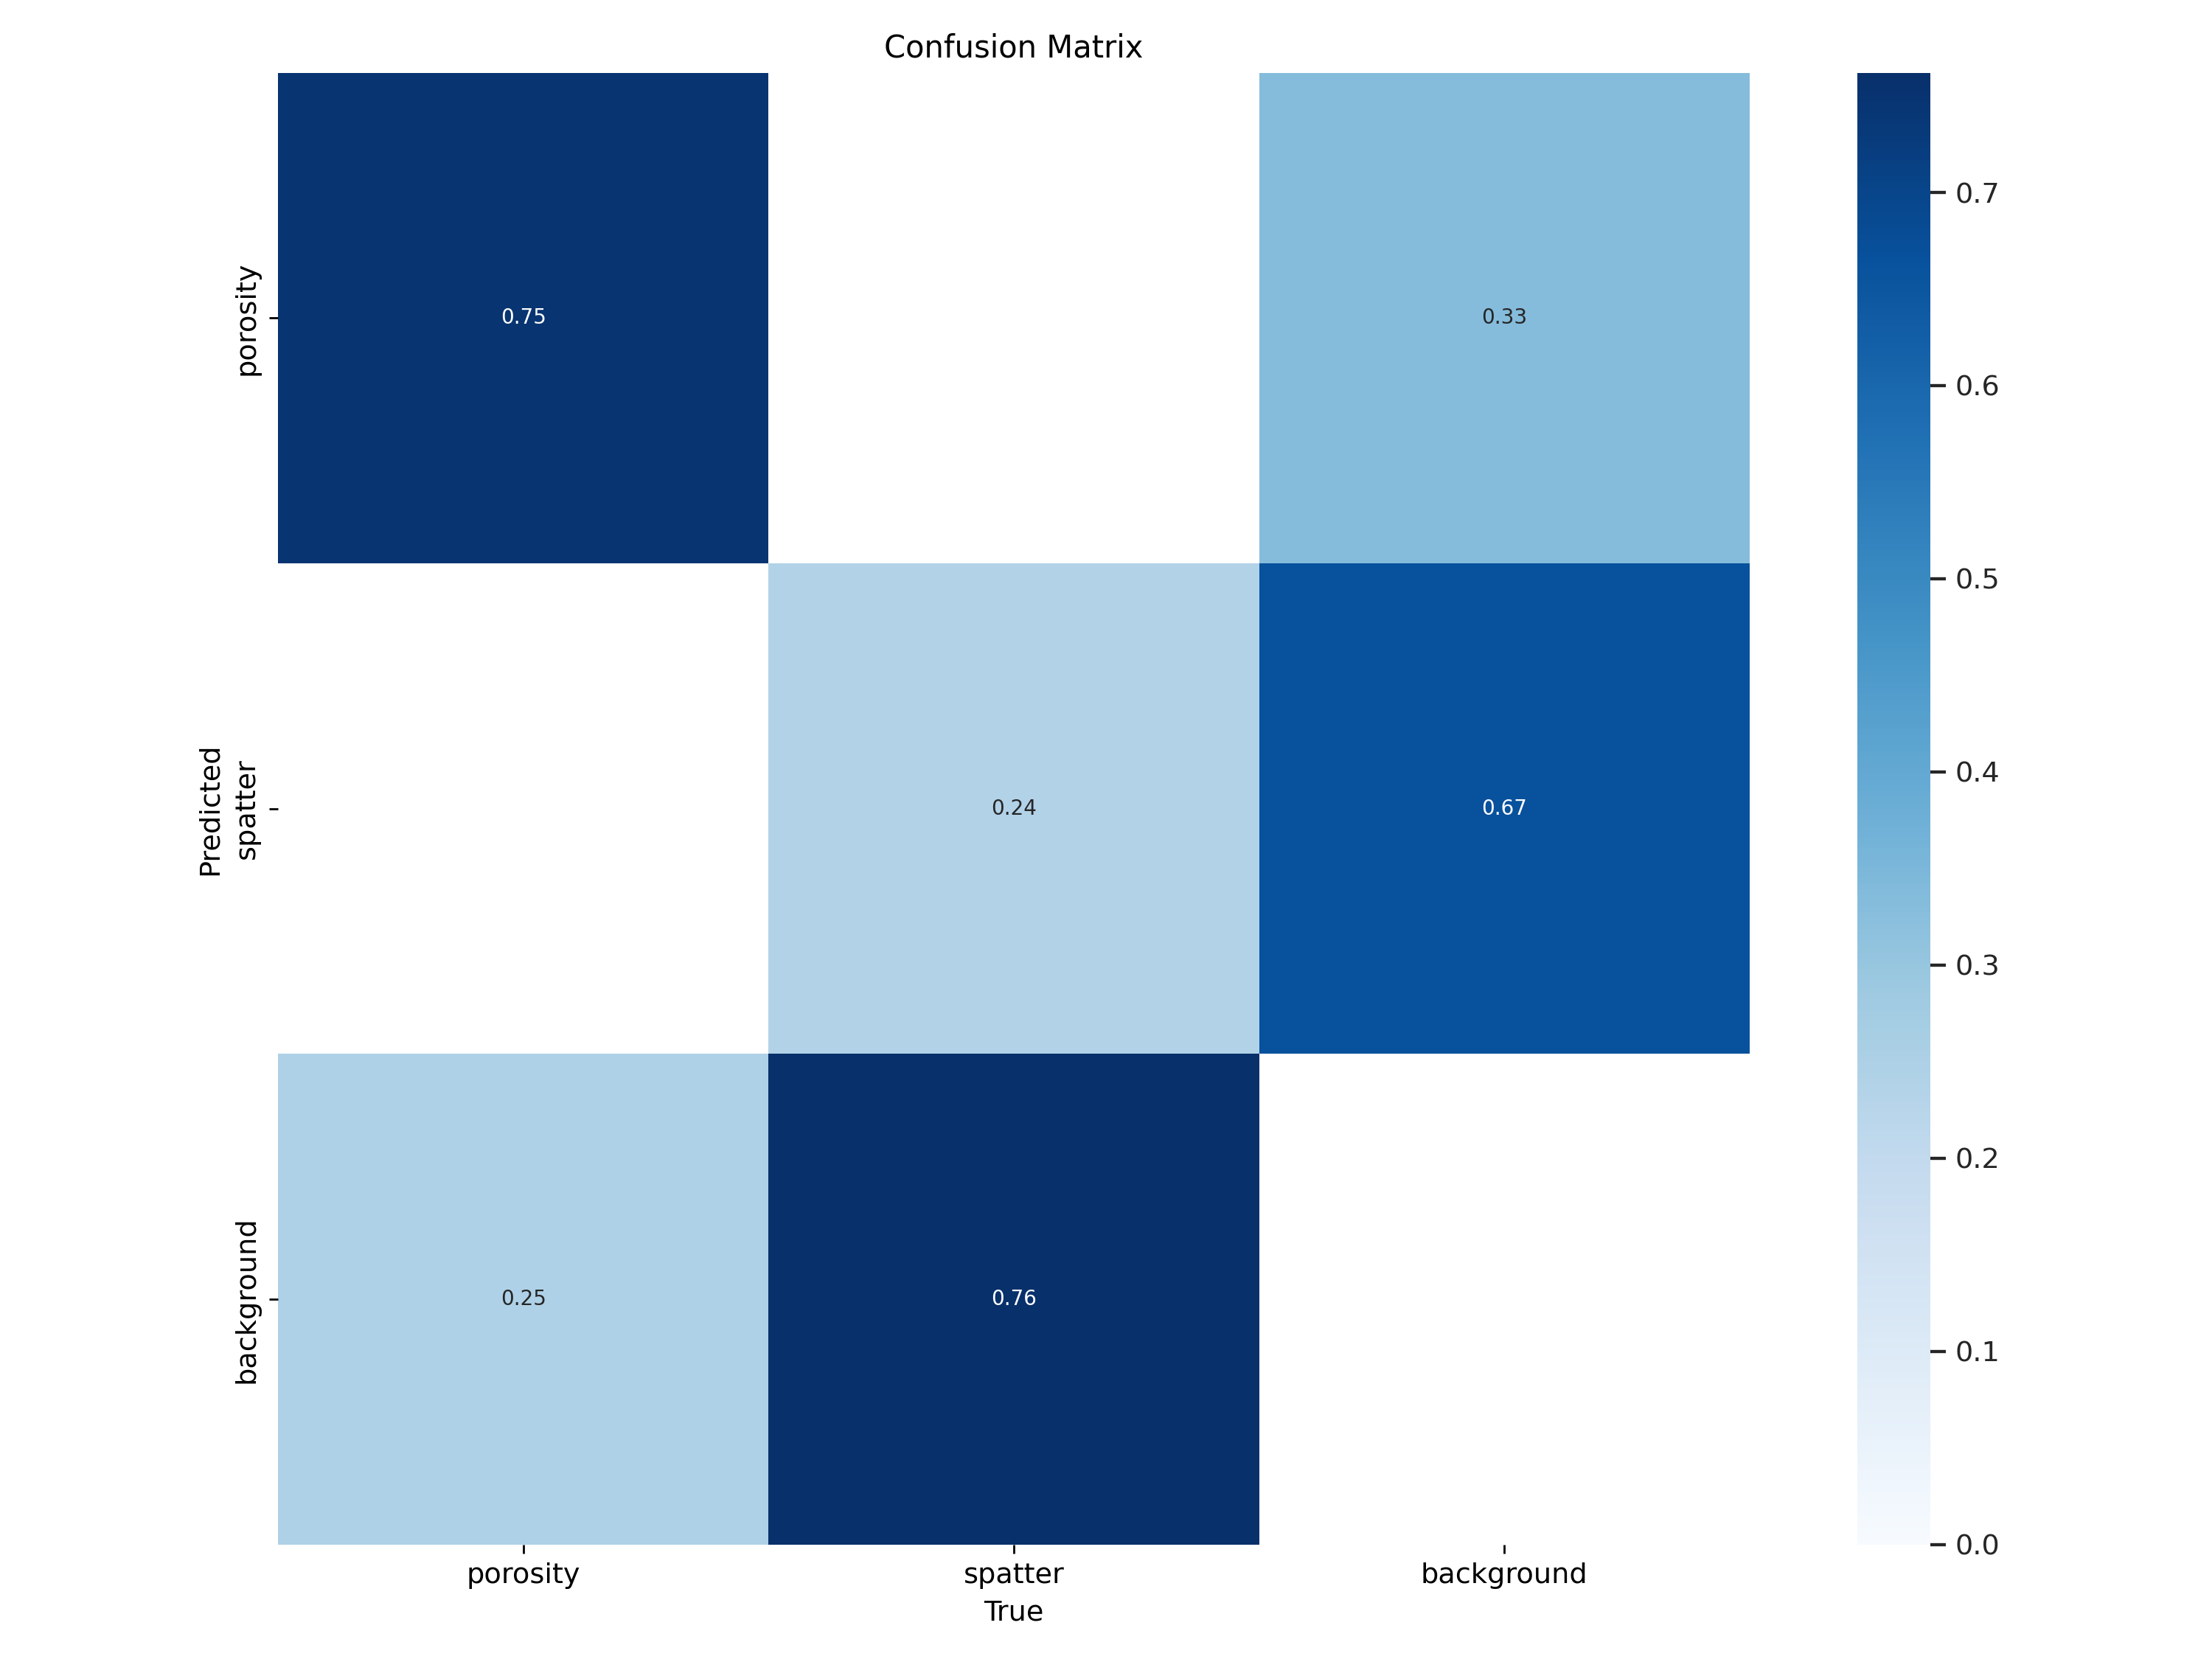

In [17]:
Image(filename='/kaggle/working/yolov5/runs/train/yolov5s_results/confusion_matrix.png', width=600)

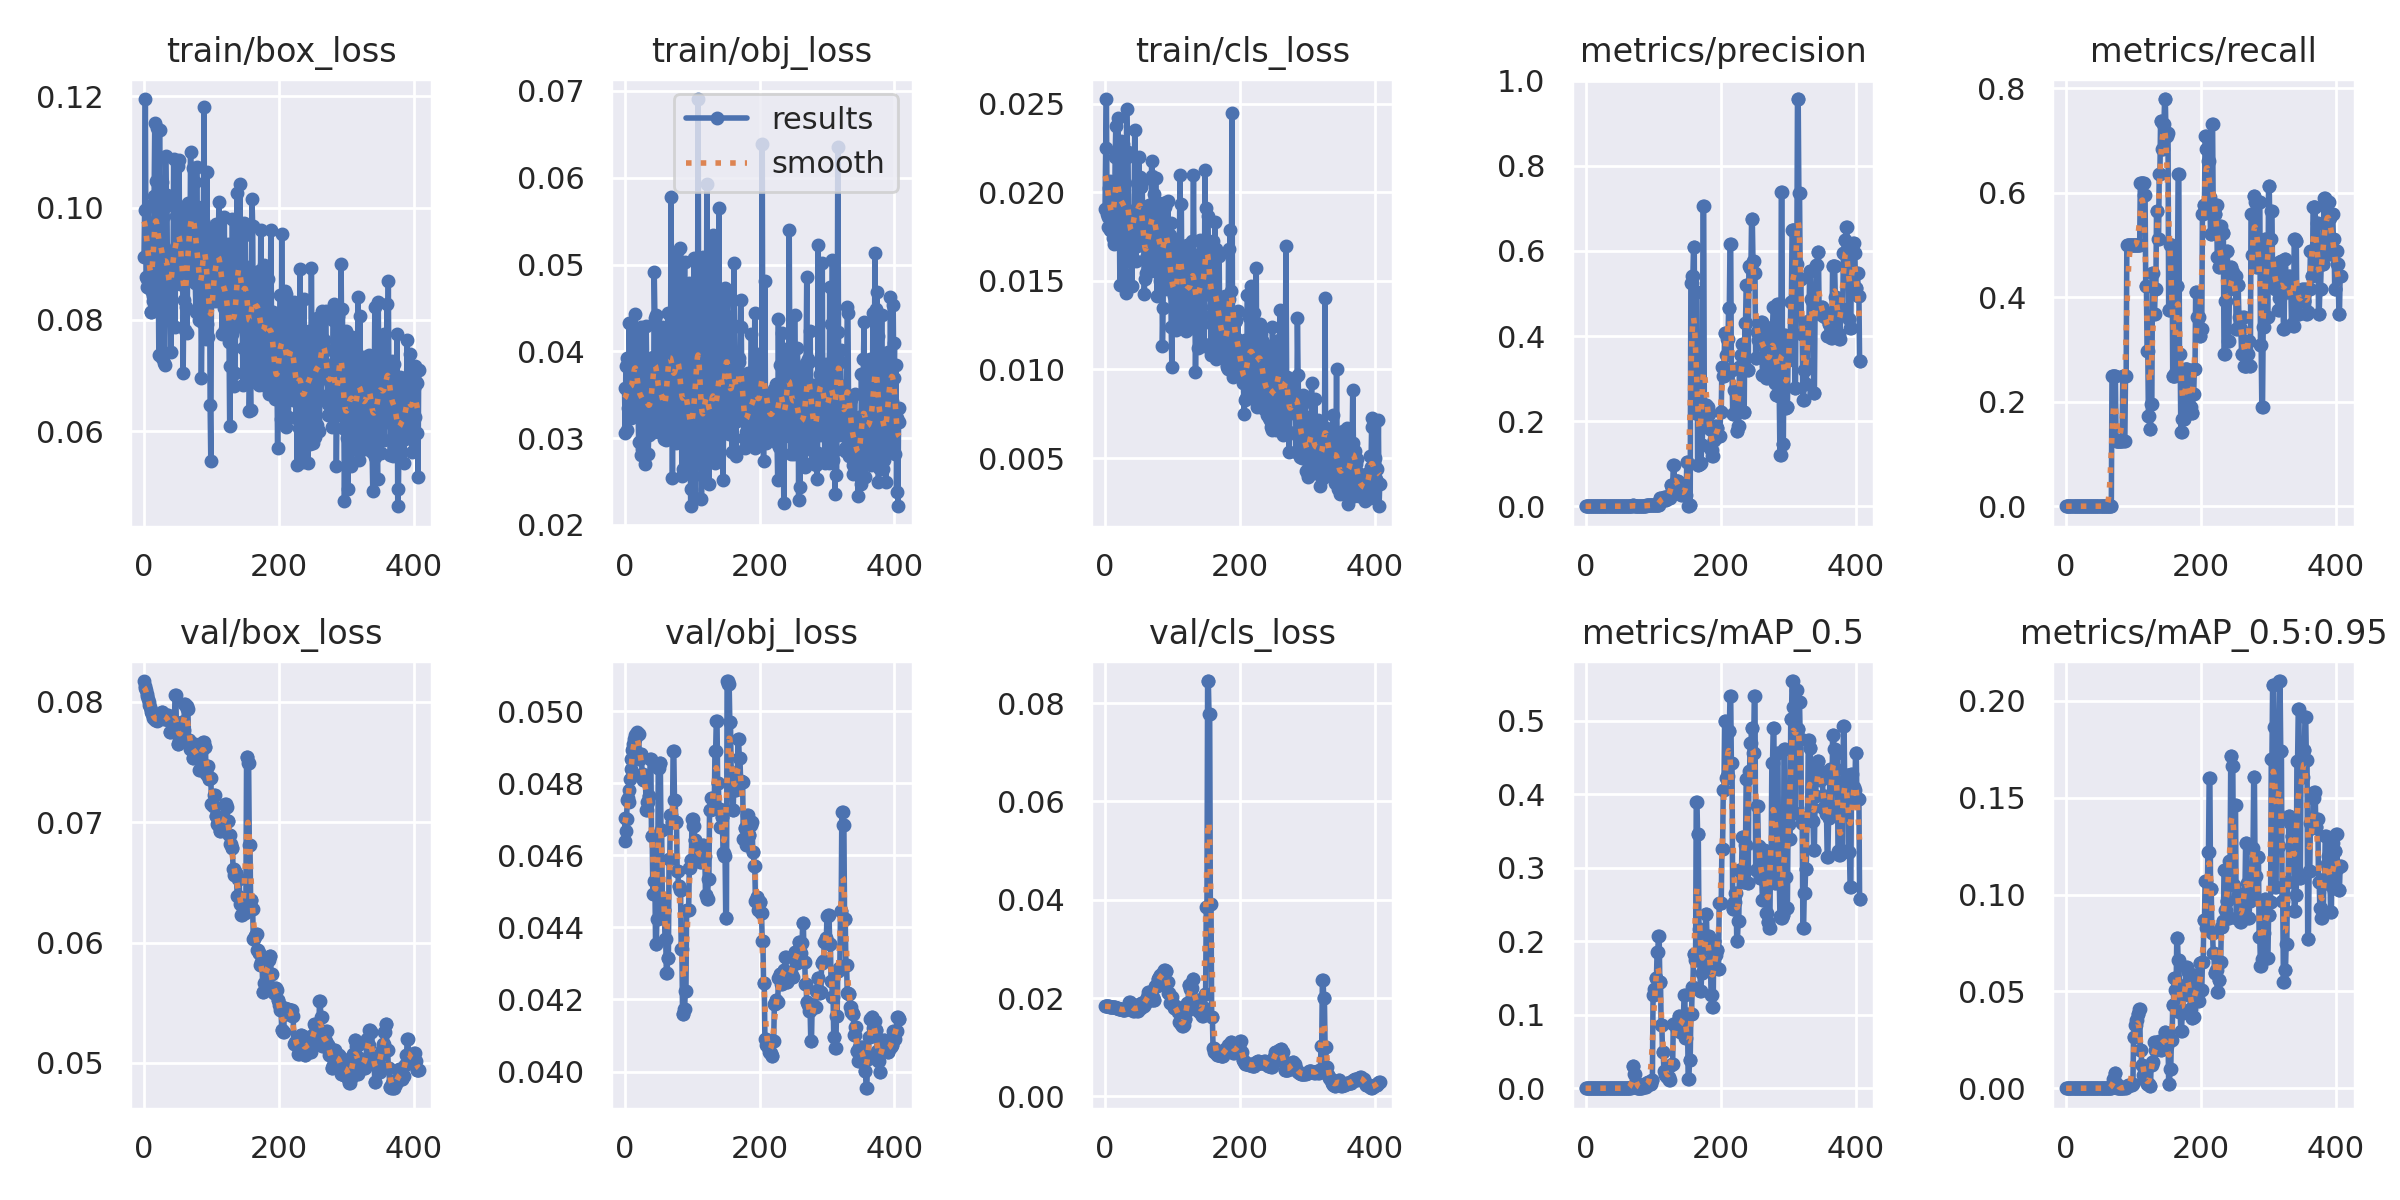

In [19]:
Image(filename='/kaggle/working/yolov5/runs/train/yolov5s_results/results.png', width=1000)

# Validate the model

In [22]:
!python val.py --weights /kaggle/working/yolov5/runs/train/yolov5s_results/weights/best.pt  --data /kaggle/working/yolov5/data.yaml --img 640


val: data=/kaggle/working/yolov5/data.yaml, weights=['/kaggle/working/yolov5/runs/train/yolov5s_results/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-303-gcf8b67b7 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7249215 parameters, 0 gradients
val: Scanning /kaggle/working/yolov5/validation/labels.cache... 3 images, 0 back
val: WARNING ⚠️ /kaggle/working/yolov5/validation/images/20230915_131702.jpg: corrupt JPEG restored and saved
                 Class     Images  Instances          P          R      mAP50   
                   all          3         25      0.653      0.423      0.554        0.2
              porosity          3          4     

# Inference with model

In [23]:
!python detect.py --weights /kaggle/working/yolov5/runs/train/yolov5s_results/weights/best.pt  --img 640 --conf 0.1 --source /kaggle/working/yolov5/test 

detect: weights=['/kaggle/working/yolov5/runs/train/yolov5s_results/weights/best.pt'], source=/kaggle/working/yolov5/test, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-303-gcf8b67b7 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7249215 parameters, 0 gradients
image 1/2 /kaggle/working/yolov5/test/20230915_131308.jpg: 320x640 26 spatters, 42.1ms
image 2/2 /kaggle/working/yolov5/test/IMG_20230919_110710.jpg: 320x640 9 porositys, 7.3ms
Speed: 0.5ms pre-process, 24.7ms inference, 151.8ms NMS per image at shape (1, 3, 640, 640)
Results saved to

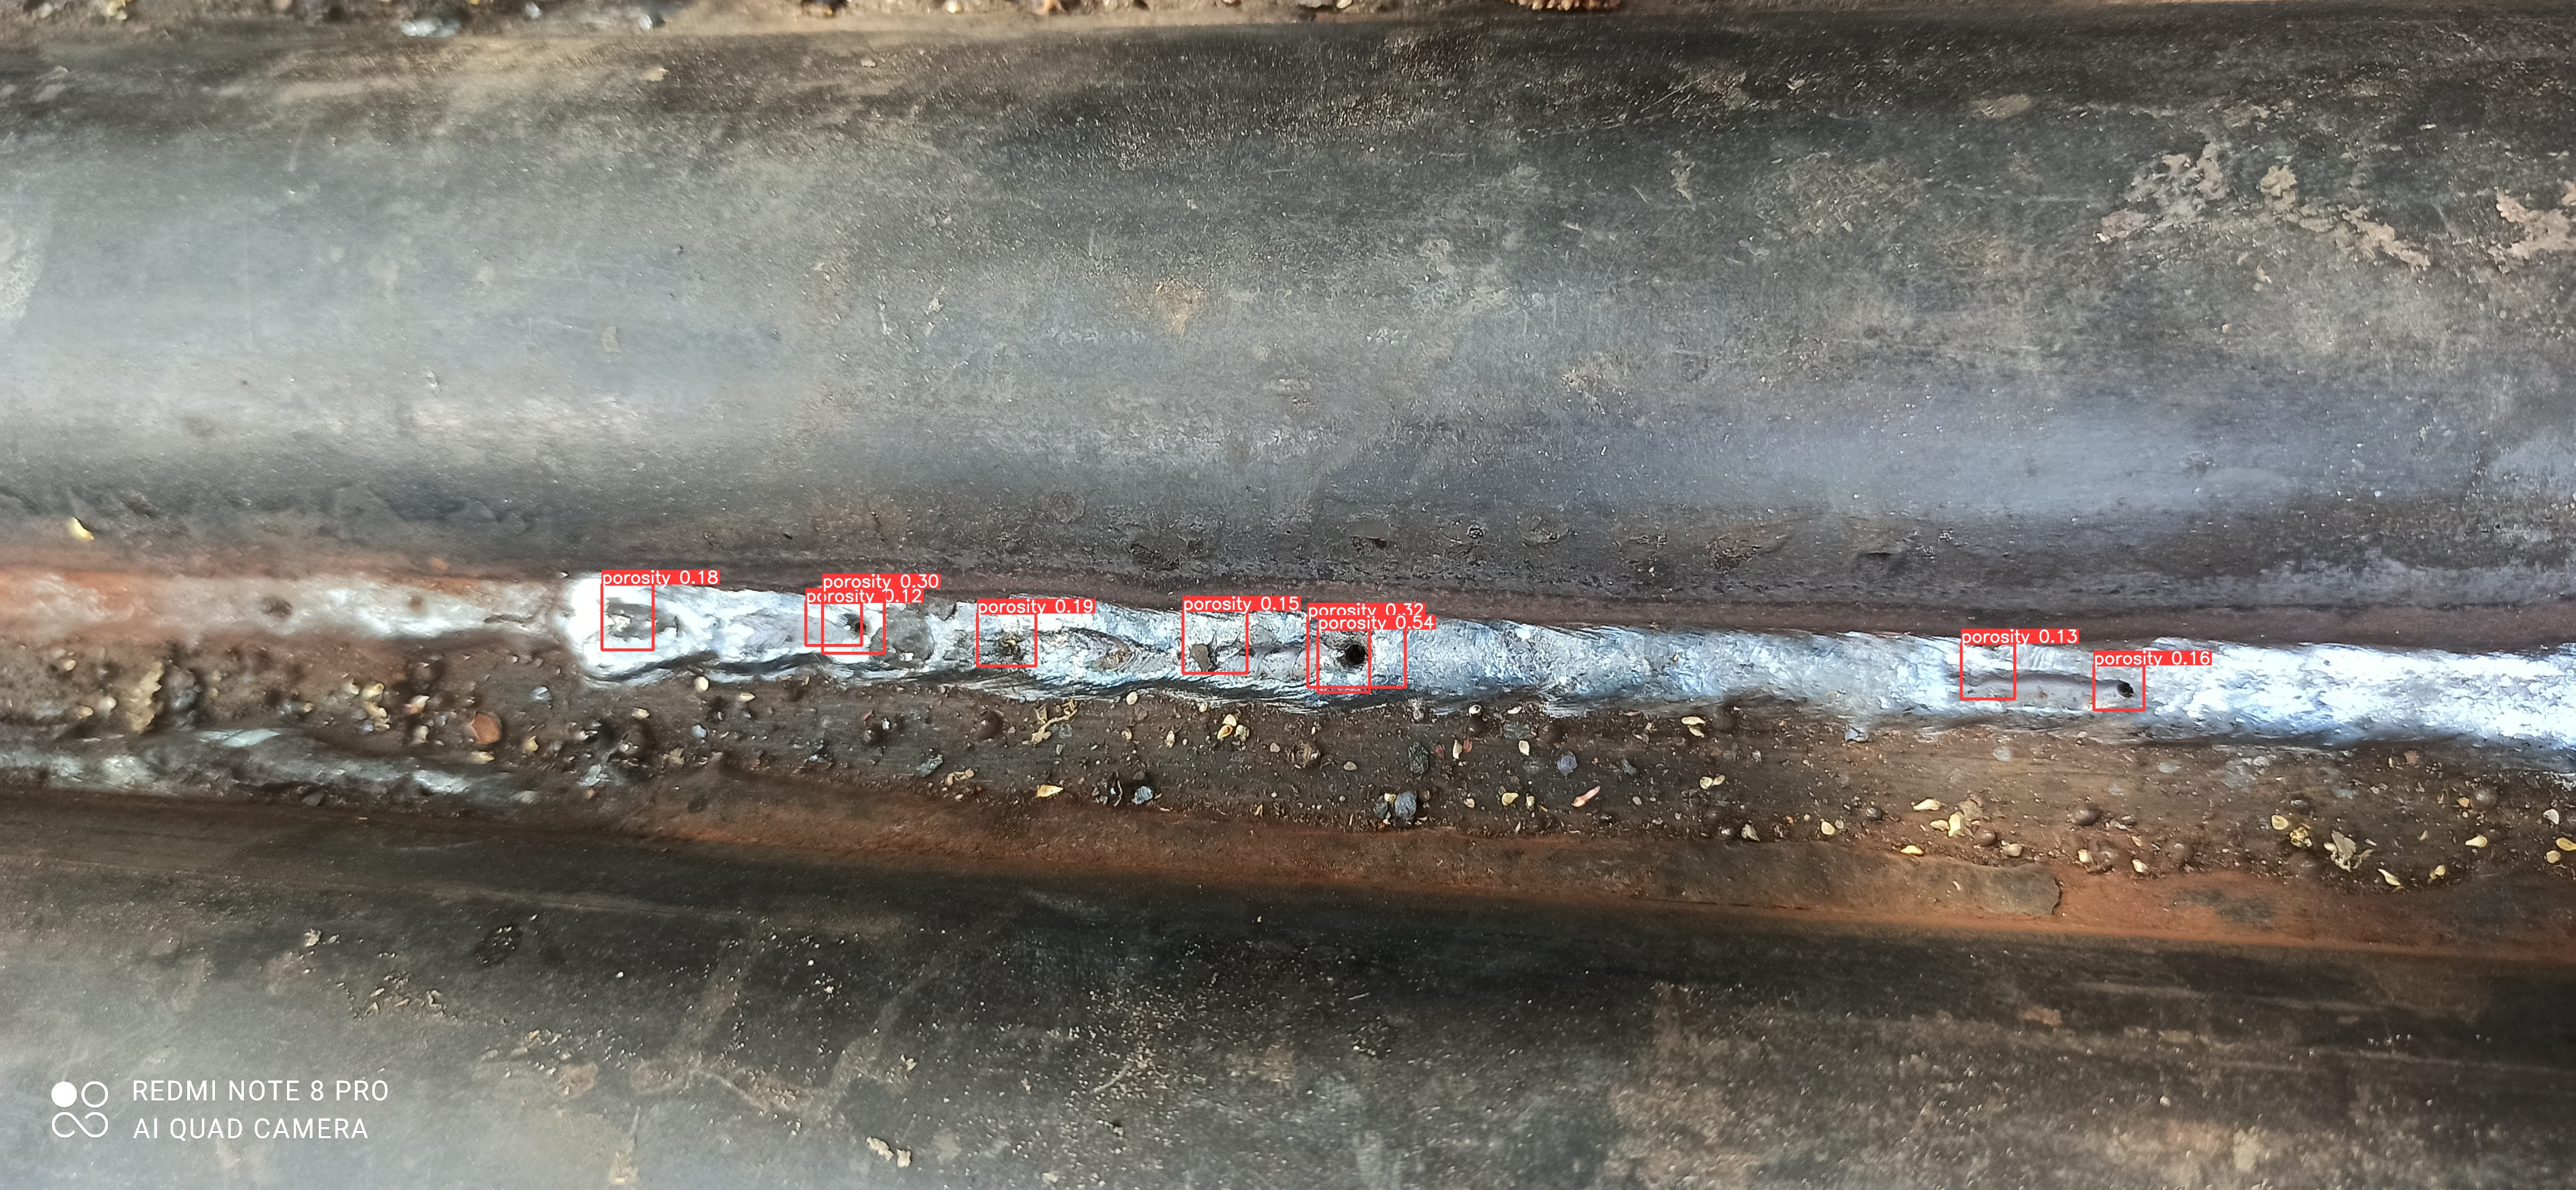

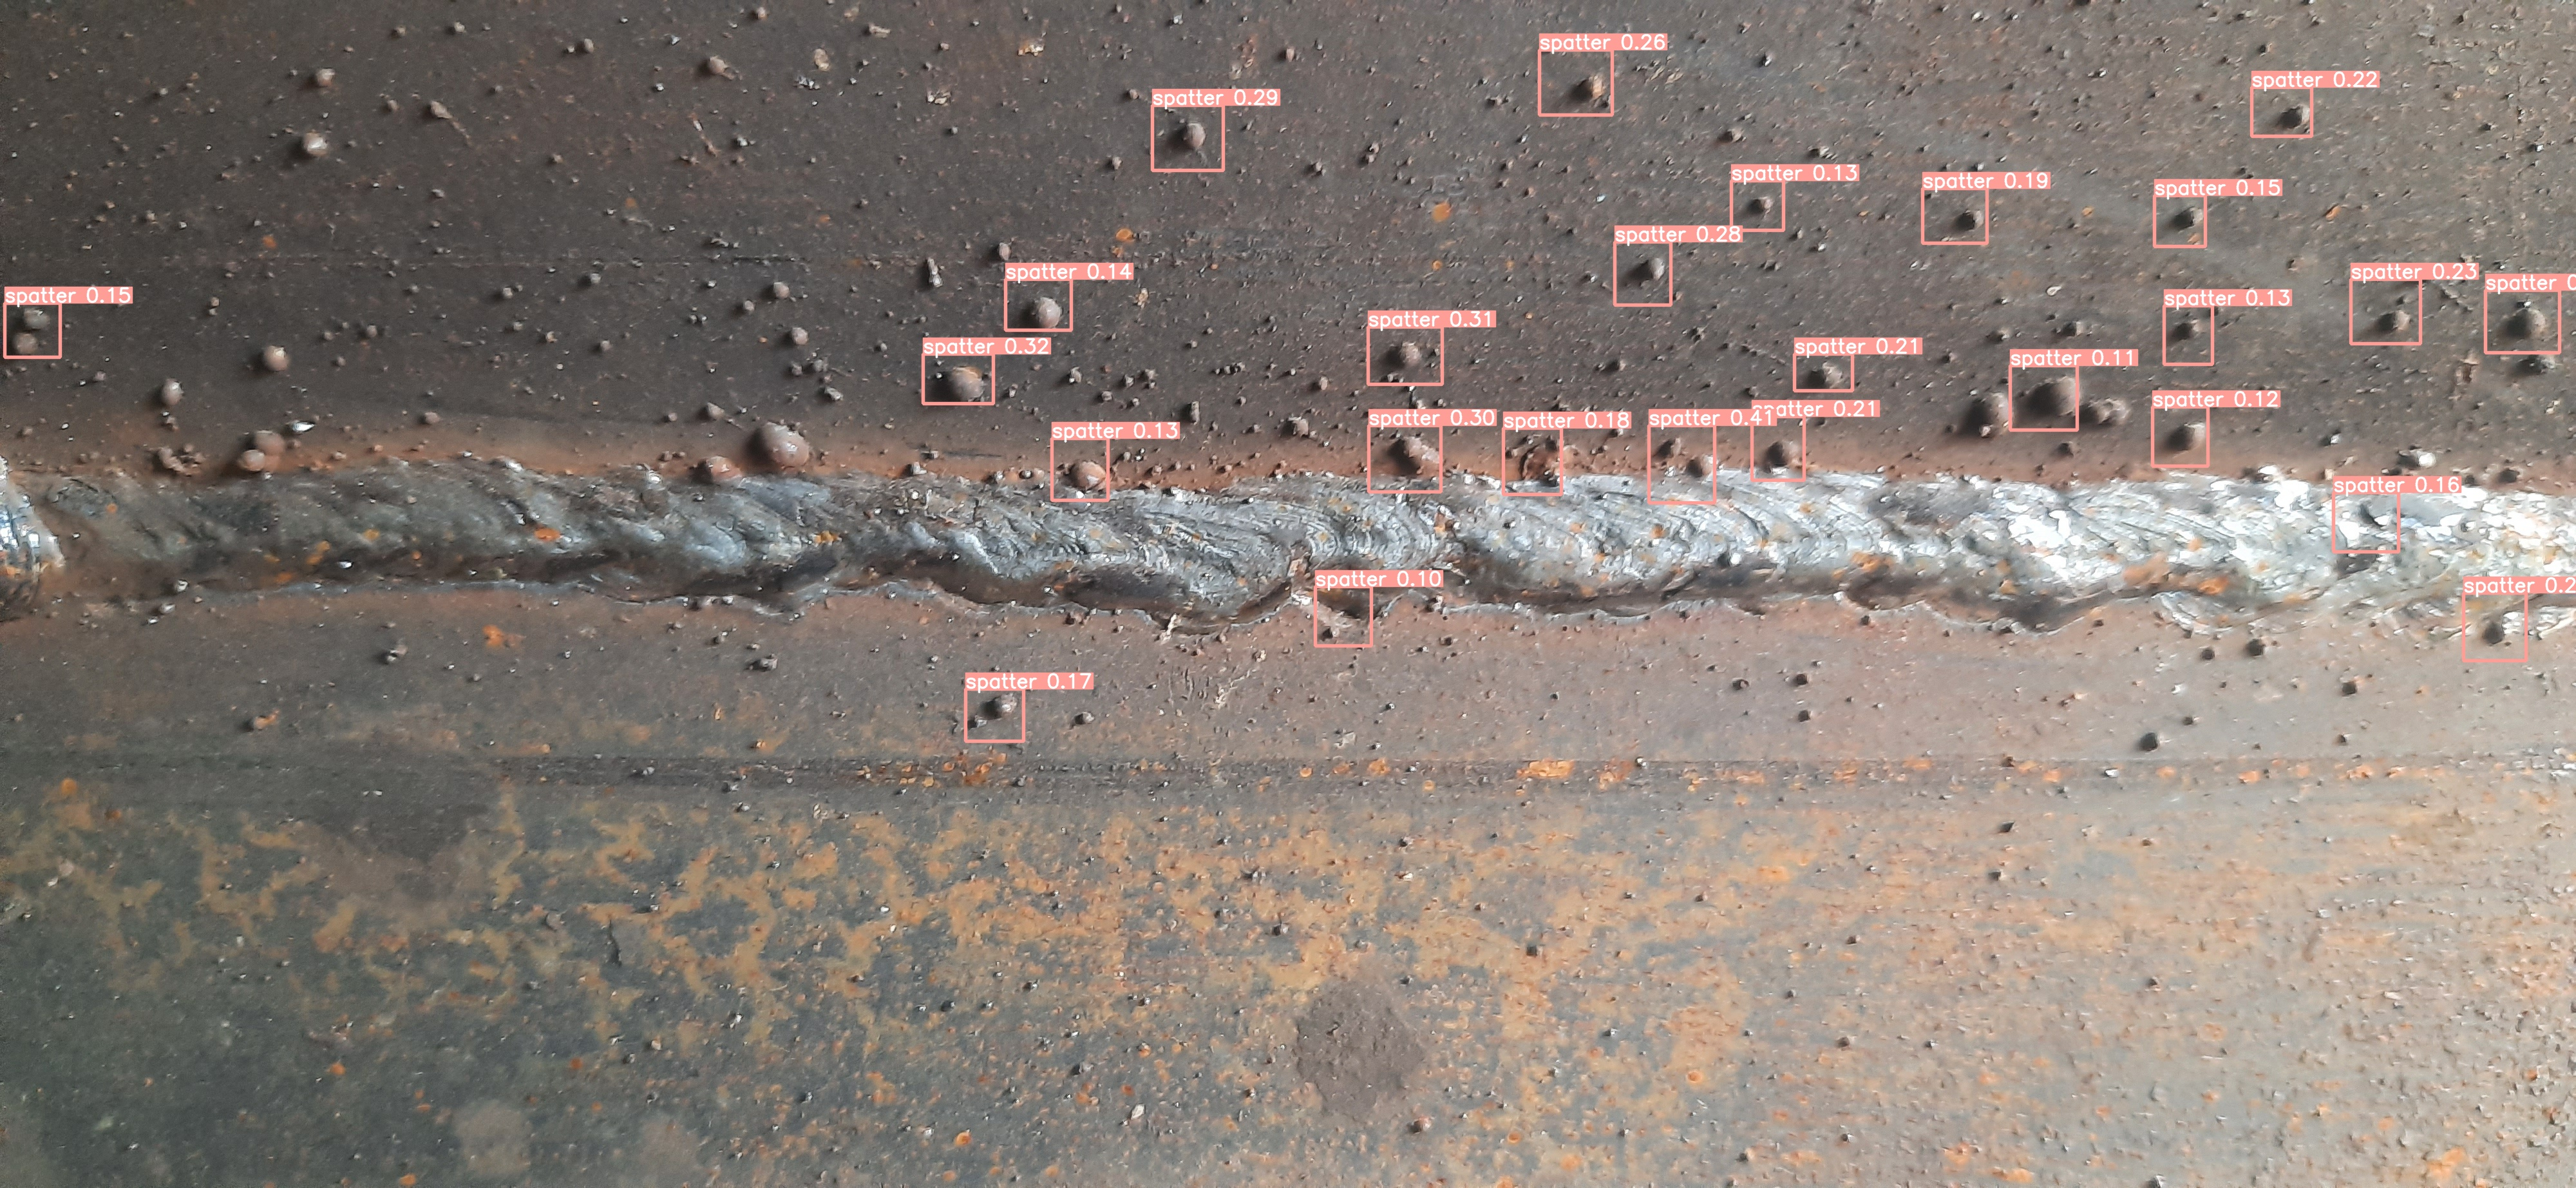

In [24]:
import glob
from IPython.display import Image, display

for image_path in glob.glob('/kaggle/working/yolov5/runs/detect/exp/*.jpg')[:2]:
      display(Image(filename=image_path, width=600))
      print("\n")

In [25]:
#converting the runs folder into zip
import shutil
shutil.make_archive("yolov5_result", 'zip', "/kaggle/working/yolov5/runs")

'/kaggle/working/yolov5/yolov5_result.zip'